In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

In [65]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [66]:
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

# Split our data into Build, Development and Test sets.
Xtr, Ytr = build_dataset(words[:n1], logging=True)
Xdev, Ydev = build_dataset(words[n1:n2], logging=True)
Xte, Yte = build_dataset(words[n2:], logging=True)

Input: torch.Size([182545, 3]), Output: torch.Size([182545])
Input: torch.Size([22739, 3]), Output: torch.Size([22739])
Input: torch.Size([22862, 3]), Output: torch.Size([22862])


In [202]:
def plot_2d_characters(C: torch.tensor, size: int = 8) -> None:
    """
    Given a look-up table C of 2D character representations plot them on the grid.
    Args:
        C(torch.tensor, shape=[num_characters, 2]): Look-up table.
        size(int)                                 : Size of the plot.
    """
    vowels = ['a', 'e', 'i', 'o', 'u']  # list of all vowels in alphabet
    colors = ['red' if itos[ch] in vowels else 'blue' for ch in range(C.shape[0])]  # color vowels red
    colors[stoi['.']] = 'green'  # color '.' token green

    plt.figure(figsize=(size, size))
    plt.scatter(C[:, 0].data, C[:, 1].data, s=200, c=colors)
    for i in range(C.shape[0]):
        plt.text(C[i, 0].data, C[i, 1].data, itos[i], ha='center', va='center', color='white')
    plt.grid('minor')

In [182]:
# Initialize model
g = torch.Generator().manual_seed(13)
C = torch.randn(size=[27, 2], generator=g)
W1 = torch.randn([6, 300], generator=g)   # 100 ---> 300
b1 = torch.randn([300], generator=g)      # 100 ---> 300
W2 = torch.randn([300, 27], generator=g)  # 100 ---> 300
b2 = torch.randn([27], generator=g)

parameters = [C, W1, b1, W2, b2]
print('Total parameters:', sum(p.nelement() for p in parameters))

# Tell torch to compute gradients for created parameters.
for p in parameters:
    p.requires_grad = True

Total parameters: 10281


In [183]:
# Save initial character 2D representations.
C_init = C.clone()

In [184]:
# Create values for learning rate.
lre = torch.linspace(-3, 0, steps=1000)
lrs = 10 ** lre

In [194]:
lri = []
lossi = []
stepi = []

for i in range(30000):

    """Mini-batch construct"""
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    """Forward pass"""
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss. item())
    
    """Backward pass"""
    for p in parameters:
        p.grad = None
    loss.backward()
    
    """Update"""
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    """Track stats"""
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

In [185]:
def evaluate_loss(input: torch.tensor, target: torch.tensor) -> torch.tensor:
    """
    Evaluate loss on given Input and Target sets.
    Args:
        input(torch.tensor, shape=[num_examples, contex_size]): Input set (X).
        target(torch.tensor, shape=[num_examples]): Target set (Y).
    Returns:
        loss(torch.tensor, shape=[]): evaluated loss.
    """
    emb = C[input]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, target)
    return loss

In [195]:
devloss = evaluate_loss(Xtr, Ytr)
print("Train Loss:", devloss.item())

devloss = evaluate_loss(Xdev, Ydev)
print("Dev Loss:", devloss.item())

Train Loss: 2.2666001319885254
Dev Loss: 2.2746448516845703


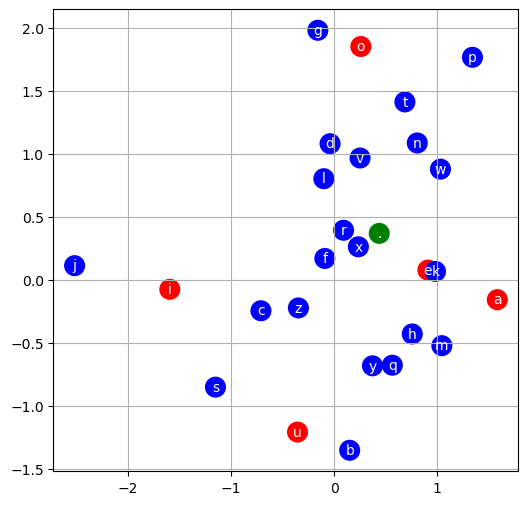

In [206]:
plot_2d_characters(C_init, 6)  # Plot representations before training.

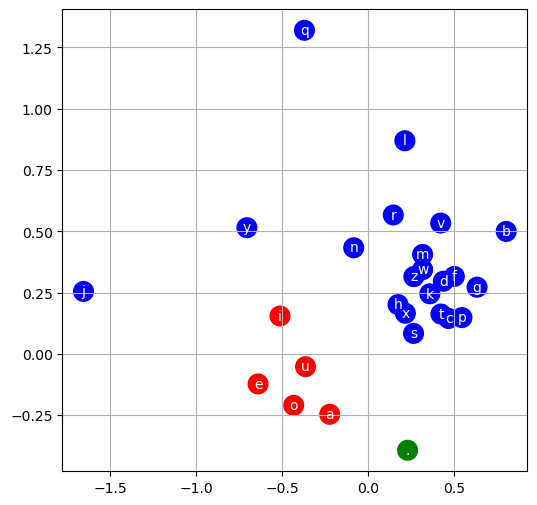

In [207]:
plot_2d_characters(C, 6)  # Plot representations after training.

In [ ]:
# Training done it's job and the plot above proves it.
# Randomly distributed characters noticably got clustered.
# Vowels (colored red) separated from consonants (colored blue).
# Model also learned to treat '.' token differently.
# Consonants 'j', 'q', 'y', 'l' flew off their cluster somewhy.